# Week 13 - Decision Tree - with Exercises Solutions

The following is adapted from **Chapter 6 of Hands-on Machine Learning** book. Please refer to Chapter 6 of the Hands-on Machine Learning book, accessible via the link provided in the course outline.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/06_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/06_decision_trees.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys
import graphviz

assert sys.version_info >= (3, 7)

# requires Scikit-Learn ≥ 1.0.1:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# define the default font sizes to make the figures prettier

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)# define the default font sizes to make the figures prettier

And let's create the `images/decision_trees` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Decision Trees

Decision trees are versatile machine learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets. For example, in Chapter 2 you trained a `DecisionTreeRegressor` model on the California housing dataset, fitting it perfectly (actually, overfitting it).

Decision trees are also the fundamental components of random forests (see Chapter 7), which are among the most powerful machine learning algorithms available today.

In this chapter we will start by discussing how to train, visualize, and make predictions with decision trees. Then we will go through the CART training algorithm used by Scikit-Learn, and we will explore how to regularize trees and use them for regression tasks. Finally, we will discuss some of the limitations of decision trees.




# Training and Visualizing a Decision Tree

To understand decision trees, let’s build one and take a look at how it makes predictions. The following code trains a `DecisionTreeClassifier` on the `iris` dataset (see Chapter 4):

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

You can visualize the trained decision tree by first using the `export_graphviz()` function to output a graph definition file called `iris_tree.dot`:

In [4]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  # path differs in the book
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Then you can use `graphviz.Source.from_file()` to load and display the file in a Jupyter notebook:

Before you execute the code below, please make sure that you have installed modules `graphviz`, `python-graphviz` and `pydot`.
```markdown

conda install graphviz

conda install python-graphviz

conda install pydot
```

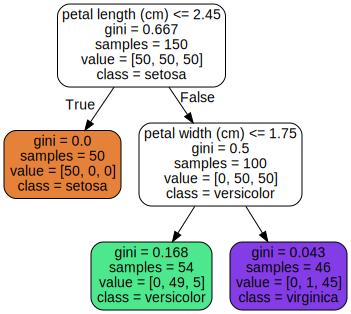

In [5]:
# the first decision tree

from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")  # path differs in the book

---
**TIP**

The tree structure, including all the information shown in the figure above, is available via the classifier’s tree_ attribute. Type `help(tree_clf.tree_)` for details, and see the this chapter’s notebook for an example.

---


Graphviz also provides the `dot` command line tool to convert `.dot` files to a variety of formats. The following command converts the dot file to a png image:

In [6]:
# extra code
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"}

# Making Predictions

Let’s see how the tree represented in Figure 6-1 makes predictions. Suppose you find an iris flower and you want to classify it based on its petals. You start at the `root node` (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a `leaf node` (i.e., it does not have any child nodes), so it does not ask any questions: simply look at the predicted class for that node, and the decision tree predicts that your flower is an _Iris setosa_ (`class=setosa`).

Now suppose you find another flower, and this time the petal length is greater than 2.45 cm. You again start at the root but now move down to its right child node (depth 1, right). This is not a leaf node, it’s a `split node`, so it asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an _Iris versicolor_ (depth 2, left). If not, it is likely an _Iris virginica_ (depth 2, right). It’s really that simple.

---

**NOTE**

One of the many qualities of decision trees is that they require very little data preparation. In fact, they don’t require feature scaling or centering at all.


---

A node’s samples attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node’s value attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 _Iris setosa_, 1 _Iris versicolor_, and 45 _Iris virginica_. Finally, a node’s `gini` attribute measures its `Gini impurity`: a node is “pure” (`gini=0`) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to Iris setosa training instances, it is pure and its Gini impurity is 0. Equation 6-1 shows how the training algorithm computes the Gini impurity Gi of the ith node. The depth-2 left node has a Gini impurity equal to $1 – (0/54)^2 – (49/54)^2 – (5/54)^2 ≈ 0.168$.


**Equation 6-1. Gini impurity**

$$

G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2

$$

In this equation:

- $G_i$ is the Gini impurity of the $i_{th}$ node.

- $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i_{th}$ node.

---
**NOTE**

Scikit-Learn uses the CART algorithm, which produces only binary trees, meaning trees where split nodes always have exactly two children (i.e., questions only have yes/no answers). However, other algorithms, such as ID3, can 
produce decision trees with nodes that have more than two children.

---









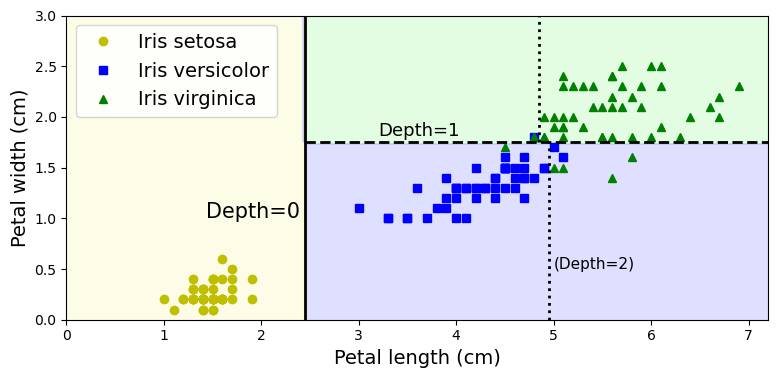

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies and saves Figure 6–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_decision_boundaries_plot")

plt.show()

Figure above shows this decision tree’s decision boundaries. The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45 cm. Since the lefthand area is pure (only Iris setosa), it cannot be split any further. However, the righthand area is impure, so the depth-1 right node splits it at petal width = 1.75 cm (represented by the dashed line). Since `max_depth` was set to 2, the decision tree stops right there. If you set `max_depth` to 3, then the two depth-2 nodes would each add another decision boundary (represented by the two vertical dotted lines).




You can access the tree structure via the `tree_` attribute:

In [8]:
tree_clf.tree_

For more information, check out this class's documentation:

In [9]:
# help(sklearn.tree._tree.Tree)

---

**MODEL INTERPRETATION: WHITE BOX VERSUS BLACK BOX**

Decision trees are intuitive, and their decisions are easy to interpret. Such models are often called `white box models`. In contrast, as you will see, random forests and neural networks are generally considered `black box models`. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. For example, if a neural network says that a particular person appears in a picture, it is hard to know what contributed to this prediction: Did the model recognize that person’s eyes? Their mouth? Their nose? Their shoes? Or even the couch that they were sitting on? Conversely, decision trees provide nice, simple classification rules that can even be applied manually if need be (e.g., for flower classification). The field of _interpretable ML_ aims at creating ML systems that can explain their decisions in a way humans can understand. This is important in many domains—for example, to ensure the system does not make unfair decisions.

---

# Estimating Class Probabilities

A decision tree can also estimate the probability that an instance belongs to a particular class k. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node. For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the decision tree outputs the following probabilities: 0% for _Iris setosa_ (0/54), 90.7% for _Iris versicolor_ (49/54), and 9.3% for _Iris virginica_ (5/54). And if you ask it to predict the class, it outputs _Iris versicolor_ (class 1) because it has the highest probability. Let’s check this:



In [10]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [11]:
tree_clf.predict([[5, 1.5]])

array([1])

Perfect! Notice that the estimated probabilities would be identical anywhere else in the bottom-right rectangle of Figure above—for example, if the petals were 6 cm long and 1.5 cm wide (even though it seems obvious that it would most likely be an _Iris virginica_ in this case).

# The CART Training Algorithm

Scikit-Learn uses the `Classification and Regression Tree (CART) algorithm` to train decision trees (also called “growing” trees). The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). How does it choose k and tk? It searches for the pair ($k$, $t_k$) that produces the purest subsets, weighted by their size. Equation 6-2 gives the cost function that the algorithm tries to minimize.

**Equation 6-2. CART cost function for classification**

$$ J(k, t_k) = \frac{m_{\mathrm{left}}}{m} G_{\mathrm{left}} + \frac{m_{\mathrm{right}}}{m} G_{\mathrm{right}} $$

where 

- $ G_{\mathrm{left}/\mathrm{right}} $ measures the impurity of the left/right subset

- $ m_{\mathrm{left}/\mathrm{right}} $ is the number of instances in the left/right subset


Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparameters (described in a moment) control additional stopping conditions: `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, and `max_leaf_nodes`.


---
**WARNING**

As you can see, the CART algorithm is a `greedy algorithm`: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that’s reasonably good but not guaranteed to be optimal.

Unfortunately, finding the optimal tree is known to be an `NP-complete problem`.⁠ It requires `O(exp(m))` time, making the problem intractable even for small training sets. This is why we must settle for a “reasonably good” solution when training decision trees.


# Computational Complexity

Making predictions requires traversing the decision tree from the root to a leaf. Decision trees generally are approximately balanced, so traversing the decision tree requires going through roughly $O(log2(m))$ nodes, where $log_2(m)$ is the binary logarithm of $m$, equal to $log(m) / log(2)$. Since each node only requires checking the value of one feature, the overall prediction complexity is $O(log_2(m))$, independent of the number of features. So predictions are very fast, even when dealing with large training sets.

The training algorithm compares all features (or less if `max_features` is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of $O(n × m log_2(m))$.

# Gini Impurity or Entropy?

By default, the `DecisionTreeClassifier` class uses the Gini impurity measure, but you can select the entropy impurity measure instead by setting the `criterion` hyperparameter to `"entropy"`. The concept of entropy originated in thermodynamics as a measure of molecular disorder: entropy approaches zero when molecules are still and well ordered. Entropy later spread to a wide variety of domains, including in Shannon’s information theory, where it measures the average information content of a message, as we saw in Chapter 4. Entropy is zero when all messages are identical. In machine learning, entropy is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class. Equation 6-3 shows the definition of the entropy of the ith node. For example, the depth-2 left node in the top figure of the notebook has an entropy equal to $–(49/54) log_2 (49/54) – (5/54) log_2 (5/54) ≈ 0.445$.


**Equation 6-3. Entropy**


$$ H_i = -\sum_{k=1}^{n} p_{i,k} \log_2(p_{i,k}) $$

So, should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.⁠

# Regularization Hyperparameters

Decision trees make very few assumptions about the training data (as opposed to linear models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely—indeed, most likely overfitting it. Such a model is often called a `nonparametric` model, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a `parametric` model, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to restrict the decision tree’s freedom during training. As you know by now, this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the decision tree. In Scikit-Learn, this is controlled by the `max_depth` hyperparameter. The default value is `None`, which means unlimited. Reducing `max_depth` will regularize the model and thus reduce the risk of overfitting.

The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the decision tree:

- `max_features`
    - Maximum number of features that are evaluated for splitting at each node

- `max_leaf_nodes`
    - Maximum number of leaf nodes

- `min_samples_split`
    - Minimum number of samples a node must have before it can be split

- `min_samples_leaf`
    - Minimum number of samples a leaf node must have to be created

- `min_weight_fraction_leaf`
    - Same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances

Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

--- 

**NOTE**

Other algorithms work by first training the decision tree without restrictions, then pruning (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant. Standard statistical tests, such as the $\chi^2$ test (chi-squared test), are used to estimate the probability that the improvement is purely the result of chance (which is called the null hypothesis). If this probability, called the `p-value`, is higher than a given threshold (typically 5%, controlled by a hyperparameter), then the node is considered unnecessary and its children are deleted. The pruning continues until all unnecessary nodes have been pruned.

--- 


Let’s test regularization on the moons dataset, introduced in Chapter 5. We’ll train one decision tree without regularization, and another with `min_samples_leaf=5`. Here’s the code; Figure below shows the decision boundaries of each tree:




In [12]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

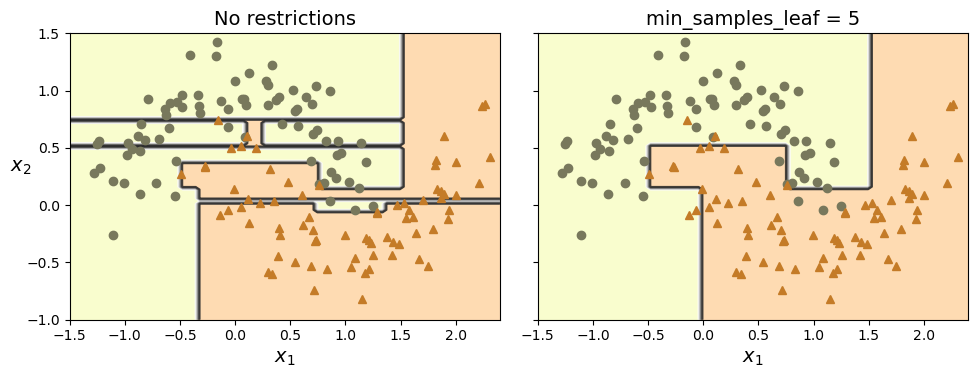

In [13]:
# extra code – this cell generates and saves Figure 6–3

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
save_fig("min_samples_leaf_plot")
plt.show()

The unregularized model on the left is clearly overfitting, and the regularized model on the right will probably generalize better. We can verify this by evaluating both trees on a test set generated using a different random seed:

In [14]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [15]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

Indeed, the second tree has a better accuracy on the test set.



# Regression


Decision trees are also capable of performing regression tasks. Let’s build a regression tree using Scikit-Learn’s `DecisionTreeRegressor` class, training it on a noisy quadratic dataset with `max_depth=2`.


Let's prepare a simple quadratic training set:

**Code example:**

In [16]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

The resulting tree is represented below: 

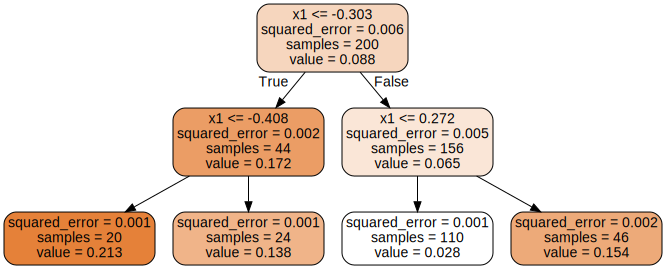

In [17]:
# extra code – we've already seen how to use export_graphviz()
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

This tree looks very similar to the classification tree you built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with $x_1 = 0.2$. The root node asks whether $x_1 ≤ 0.197$. Since it is not, the algorithm goes to the right child node, which asks whether $x_1 ≤ 0.772$. Since it is, the algorithm goes to the left child node. This is a leaf node, and it predicts $value = 0.111$. This prediction is the average target value of the 110 training instances associated with this leaf node, and it results in a mean squared error equal to 0.015 over these 110 instances.

This model’s predictions are represented on the left in Figure below. If you set `max_depth=3`, you get the predictions represented on the right. Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

In [18]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [19]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [20]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

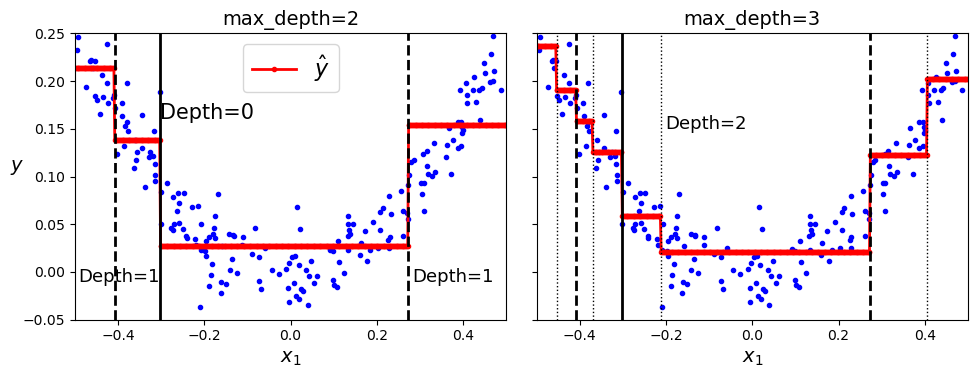

In [21]:
# extra code – this cell generates and saves Figure 6–5

def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

save_fig("tree_regression_plot")
plt.show()

The CART algorithm works as described earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE. Equation 6-4 shows the cost function that the algorithm tries to minimize.

**Equation 6-4. CART cost function for regression**

$J (k, t_k) = \frac{m_{\mathrm{left}}}{m} \text{MSE}_{\mathrm{left}} + \frac{m_{\mathrm{right}}}{m} \text{MSE}_{\mathrm{right}}$

where

- $\text{MSE}_{node} = \frac{\sum_{i \in node} (\hat{y}_{node} - y^{(i)})^2}{m_{node}}$

- $\hat{y}_{node} = \frac{\sum_{i \in node} y^{(i)}}{m_{node}}$

Just like for classification tasks, decision trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), you get the predictions on the left in Figure below. These predictions are obviously overfitting the training set very badly. Just setting `min_samples_leaf=10` results in a much more reasonable model, represented on the right in Figure below.

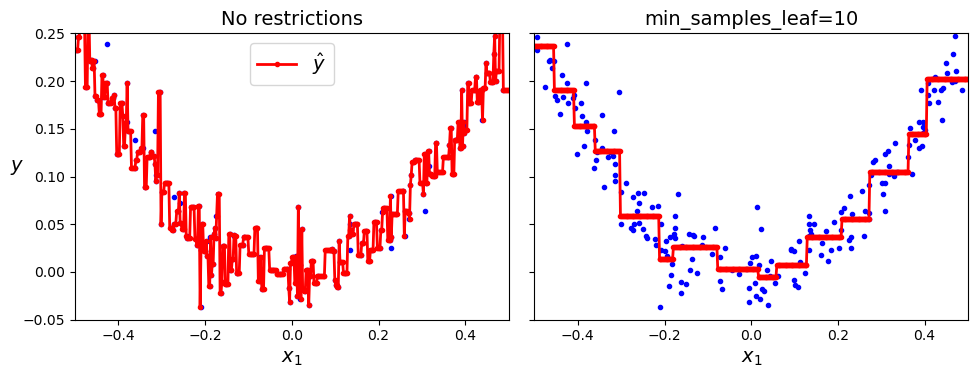

In [22]:
# extra code – this cell generates and saves Figure 6–6

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

save_fig("tree_regression_regularization_plot")
plt.show()

# Sensitivity to axis orientation



Hopefully by now you are convinced that decision trees have a lot going for them: they are relatively easy to understand and interpret, simple to use, versatile, and powerful. However, they do have a few limitations. First, as you may have noticed, decision trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to the data’s orientation. For example, Figure below shows a simple linearly separable dataset: on the left, a decision tree can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily convoluted. Although both decision trees fit the training set perfectly, it is very likely that the model on the right will not generalize well.



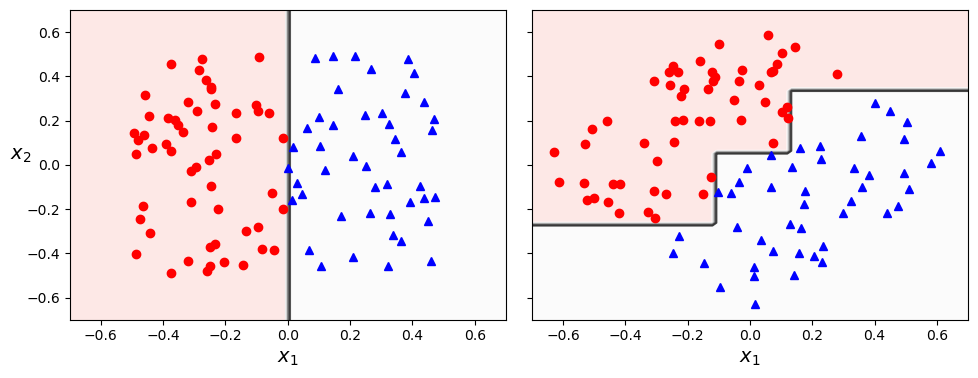

In [23]:
# extra code – this cell generates and saves Figure 6–7
# Rotating the dataset also leads to completely different decision boundaries:


np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

One way to limit this problem is to scale the data, then apply a `principal component analysis` transformation. We will look at PCA in detail in Chapter 8, but for now you only need to know that it rotates the data in a way that reduces the correlation between the features, which often (not always) makes things easier for trees.

Let’s create a small pipeline that scales the data and rotates it using PCA, then train a `DecisionTreeClassifier` on that data. Figure below shows the decision boundaries of that tree: as you can see, the rotation makes it possible to fit the dataset pretty well using only one feature, z1, which is a linear function of the original petal length and width. Here’s the code:

In [24]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

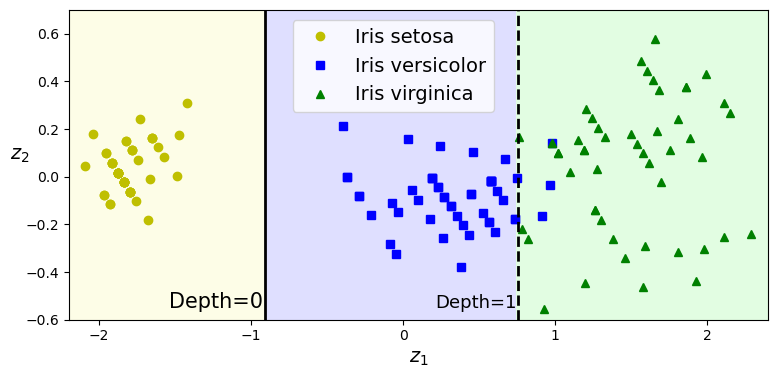

In [25]:
# extra code – this cell generates and saves Figure 6–8

plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))
save_fig("pca_preprocessing_plot")

plt.show()

# Decision Trees Have High Variance

More generally, the main issue with decision trees is that they have quite a high variance: small changes to the hyperparameters or to the data may produce very different models. In fact, since the training algorithm used by Scikit-Learn is stochastic—it randomly selects the set of features to evaluate at each node—even retraining the same decision tree on the exact same data may produce a very different model, such as the one represented in Figure below (unless you set the `random_state` hyperparameter). As you can see, it looks very different from the previous decision tree.

In [26]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

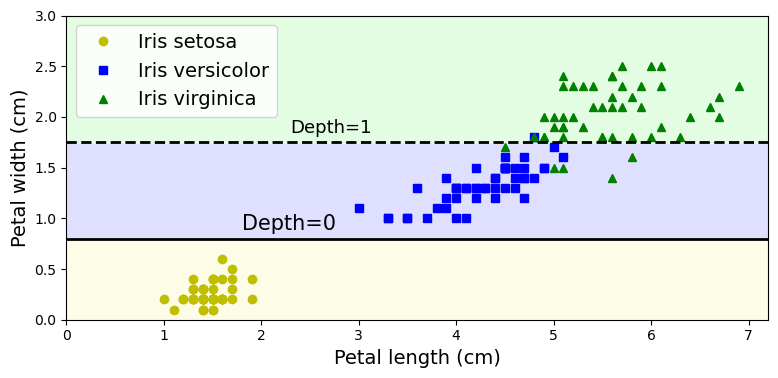

In [27]:
# extra code – this cell generates and saves Figure 6–9

plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_high_variance_plot")

plt.show()

Luckily, by averaging predictions over many trees, it’s possible to reduce variance significantly. Such an `ensemble` of trees is called a `random forest`, and it’s one of the most powerful types of models available today, as you will see in the next chapter.

# Extra Material – Accessing the tree structure

A trained `DecisionTreeClassifier` has a `tree_` attribute that stores the tree's structure:

In [28]:
tree = tree_clf.tree_
tree

You can get the total number of nodes in the tree:

In [29]:
tree.node_count

5

And other self-explanatory attributes are available:

In [30]:
tree.max_depth

2

In [31]:
tree.max_n_classes

3

In [32]:
tree.n_features

2

In [33]:
tree.n_outputs

1

In [34]:
tree.n_leaves

3

All the information about the nodes is stored in NumPy arrays. For example, the impurity of each node:

In [35]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

The root node is at index 0. The left and right children nodes of node _i_ are `tree.children_left[i]` and `tree.children_right[i]`. For example, the children of the root node are:

In [36]:
tree.children_left[0], tree.children_right[0]

(1, 2)

When the left and right nodes are equal, it means this is a leaf node (and the children node ids are arbitrary):

In [37]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

So you can get the leaf node ids like this:

In [38]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Non-leaf nodes are called _split nodes_. The feature they split is available via the `feature` array. Values for leaf nodes should be ignored:

In [39]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

And the corresponding thresholds are:

In [40]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

And the number of instances per class that reached each node is available too:

In [41]:
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [42]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [43]:
np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples)

True

Here's how you can compute the depth of each node:

In [44]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

Here's how to get the thresholds of all split nodes at depth 1:

In [45]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)